## EEG Information

1. Loading Data
    - Load csv
2. Arfitact Removal
    - transform pandas to raw mne
    - Remove Power Line Noise (50Hz, 100Hz, 150Hz, 200Hz, 250Hz)
    - Band Pass: 1 - 20 Hz

3. ICA

4. Epoching  
- tmin = -0.2
- tmax= 0.8
- events = {" non-target " : 1, " target " : 2}

In [10]:
# import library
import pandas as pd
import numpy as np
import mne
from mne import create_info
from mne.io import RawArray
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Loading Data

#### Load CSV

In [11]:
#Prepare Data 
df = pd.read_csv('group_01.csv', delimiter = ',', dtype = 'float64')
header_data = pd.read_csv('Header.csv', delimiter = ',')

#Add header to dataset
df.columns = list(header_data)
df.head()

,Time,FP1_1,FP2_1,AFZ_1,F7_1,F3_1,F4_1,F8_1,FC5_1,FC1_1,...,P8_2,PO7_2,O1_2,Oz_2,O2_2,PO8_2,PO9_2,PO10_2,Events,Target
0,0.001953,54589.0,55238.0,68817.0,61389.0,60659.0,59589.0,50781.0,58104.0,68243.0,...,24600.0,26544.0,27900.0,23125.0,20075.0,-2081.4,19024.0,-132130.0,0.0,0.0
1,0.003906,54646.0,55321.0,68880.0,61461.0,60742.0,59674.0,50868.0,58182.0,68316.0,...,24598.0,26539.0,27900.0,23126.0,20071.0,-2084.6,19019.0,-132070.0,0.0,0.0
2,0.005859,54790.0,55508.0,69034.0,61630.0,60919.0,59860.0,51062.0,58351.0,68481.0,...,24631.0,26579.0,27924.0,23162.0,20089.0,-2063.2,19067.0,-132370.0,0.0,0.0
3,0.007812,54862.0,55602.0,69114.0,61722.0,61011.0,59951.0,51157.0,58438.0,68571.0,...,24639.0,26580.0,27927.0,23151.0,20104.0,-2047.4,19069.0,-132540.0,0.0,0.0
4,0.009766,54959.0,55724.0,69222.0,61831.0,61129.0,60073.0,51279.0,58551.0,68685.0,...,24667.0,26603.0,27963.0,23175.0,20138.0,-2018.4,19098.0,-133000.0,0.0,0.0


In [12]:
df = df.drop(['Time'], axis = 1) # Drop Time column
#print(group1.columns)


#Prepare standard 10-20 systems with 32 electrodes
# chennels named according to the experiment
header = ['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'F4', 'F8', 
          'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 
          'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 
          'P3', 'Pz', 'P4', 'P8', 'PO7', 'O1', 'Oz', 
          'O2', 'PO8', 'PO9', 'PO10','Target']

In [13]:
#For Subject1

df_s1 = df.iloc[:, :32]  # Slicing data for subject1
df_s1['Target'] = df['Target'] # Add Target column
df_s1.columns = header # Add column names
df_s1.head()

,Fp1,Fp2,AFz,F7,F3,F4,F8,FC5,FC1,FC2,...,P4,P8,PO7,O1,Oz,O2,PO8,PO9,PO10,Target
0,54589.0,55238.0,68817.0,61389.0,60659.0,59589.0,50781.0,58104.0,68243.0,70366.0,...,49613.0,53932.0,57899.0,57379.0,54521.0,54029.0,55296.0,53193.0,50795.0,0.0
1,54646.0,55321.0,68880.0,61461.0,60742.0,59674.0,50868.0,58182.0,68316.0,70435.0,...,49705.0,54017.0,57997.0,57480.0,54617.0,54125.0,55391.0,53275.0,50886.0,0.0
2,54790.0,55508.0,69034.0,61630.0,60919.0,59860.0,51062.0,58351.0,68481.0,70597.0,...,49895.0,54200.0,58188.0,57672.0,54790.0,54303.0,55582.0,53470.0,51077.0,0.0
3,54862.0,55602.0,69114.0,61722.0,61011.0,59951.0,51157.0,58438.0,68571.0,70681.0,...,49979.0,54284.0,58260.0,57744.0,54860.0,54377.0,55666.0,53550.0,51164.0,0.0
4,54959.0,55724.0,69222.0,61831.0,61129.0,60073.0,51279.0,58551.0,68685.0,70793.0,...,50103.0,54404.0,58378.0,57868.0,54985.0,54499.0,55787.0,53676.0,51282.0,0.0


## 2. Artifact Removal

In [14]:
#transform pandas to mne type
def df_to_raw(df):
    
    sfreq = 512  # according to the experiment
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim'] 
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot()
    raw.plot_psd()

    return raw

_______________________RawArray for Subject1______________________
Creating RawArray with float64 data, n_channels=33, n_times=454431
    Range : 0 ... 454430 =      0.000 ...   887.559 secs
Ready.


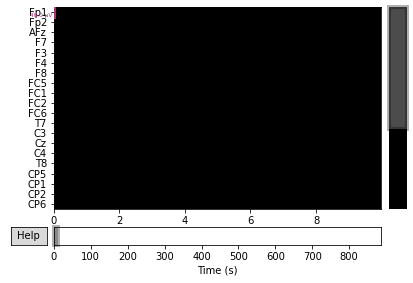

Effective window size : 4.000 (s)


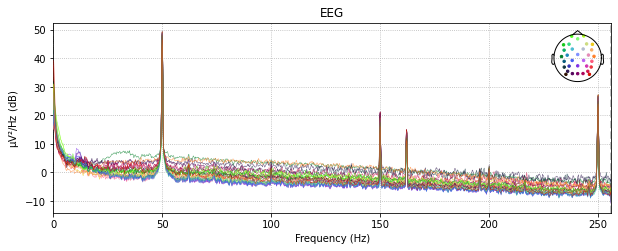

In [15]:
print("_______________________RawArray for Subject1______________________")
raw_s1 = df_to_raw(df_s1)

#### 1. Power Line noise

Remove the 50Hz power line noise and we will also remove its harmonics, i.e., 100Hz, 150Hz etc. Since our signal is 260Hz (520Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 260 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Effective window size : 4.000 (s)


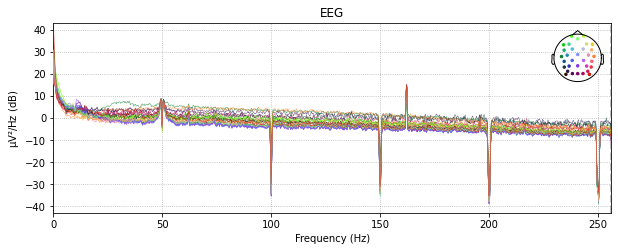

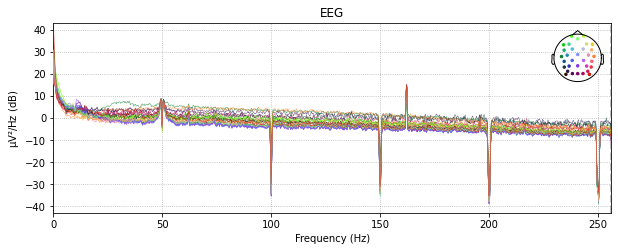

In [16]:
raw_s1.notch_filter(np.arange(50, 260, 50), filter_length='auto', phase='zero') # 520 / 2
raw_s1.plot_psd()

#### 2. Slow drift

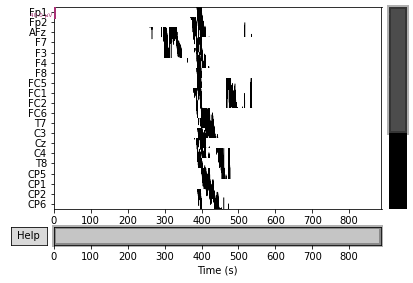

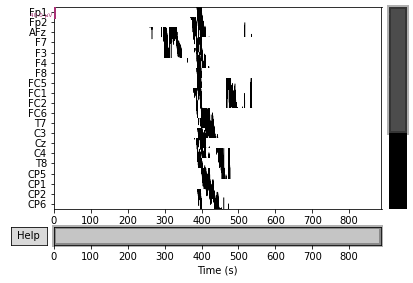

In [17]:
eeg_channels = mne.pick_types(raw_s1.info, eeg=True)
raw_s1.plot(duration=1200, order=eeg_channels) # the duration for one session is around five minutes, so 20mins(1200s) for four sessions

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16897 samples (33.002 sec)



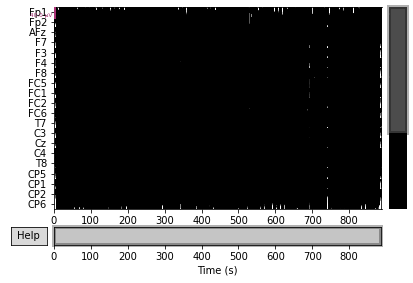

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 8449 samples (16.502 sec)



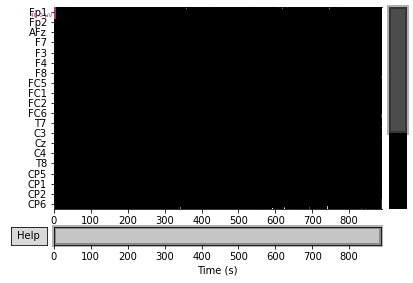

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)



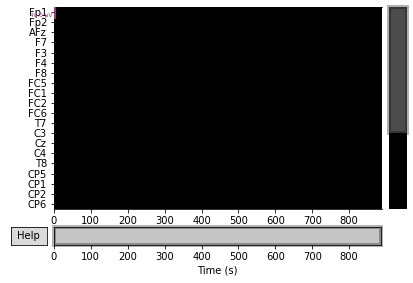

In [18]:
for cutoff in (0.1, 0.2, 1):
    raw_highpass = raw_s1.copy().filter(l_freq=cutoff, h_freq=None)
    fig = raw_highpass.plot(duration=1200, order=eeg_channels)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Looks like 0.2Hz was quite quite good to fully remove the slow drifts. Usually, 0.2Hz is a good measure since most of the brain frequency lies around 0.2 to 40Hz. We shall filter our brain signal to 1 - 15 Hz according to the paper https://hal.inria.fr/hal-00756669/document

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 15.00 Hz: -6.02, -6.02 dB

Effective window size : 4.000 (s)


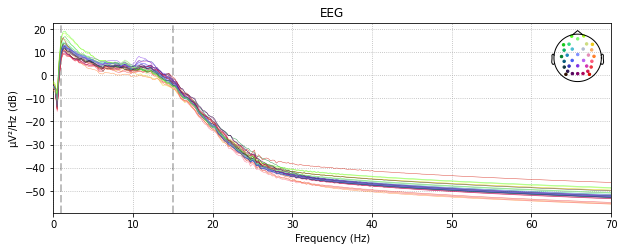

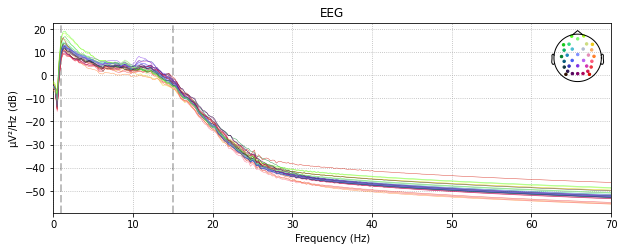

In [19]:
raw_s1.filter(1,15, method = 'iir')
raw_s1.plot_psd(fmax = 70)

#### EEG Artifacts

The types of artifacts that contaminate EEG data
 - blinks
 - muscle movements
 - brief amplifier saturations
 - line noise

### 3. Independent component analysis

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Effective window size : 4.000 (s)


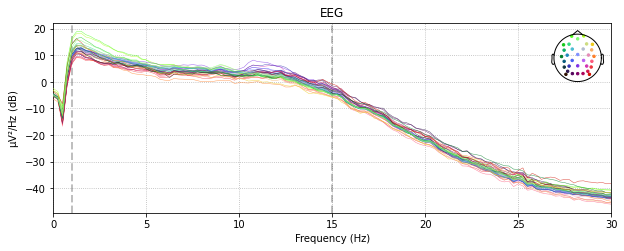

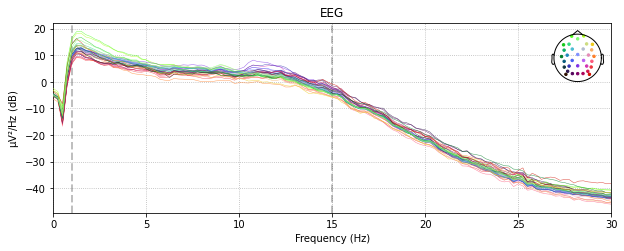

In [20]:
from mne.preprocessing import ICA

filt_raw = raw_s1.copy()
filt_raw.load_data().filter(l_freq=1.,h_freq=None)
filt_raw.plot_psd(fmax = 30)

In [21]:
ica = ICA(n_components = 32, random_state = 32)
ica.fit(filt_raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 42.4s.


<ICA | raw data decomposition, fit (fastica): 454431 samples, 32 components, channels used: "eeg">

Creating RawArray with float64 data, n_channels=32, n_times=454431
    Range : 0 ... 454430 =      0.000 ...   887.559 secs
Ready.


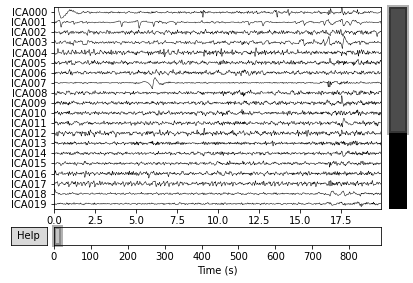

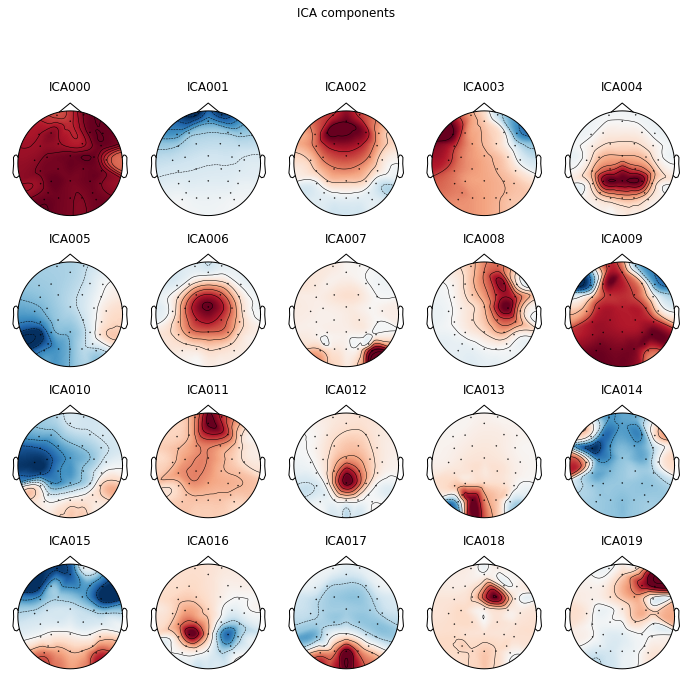

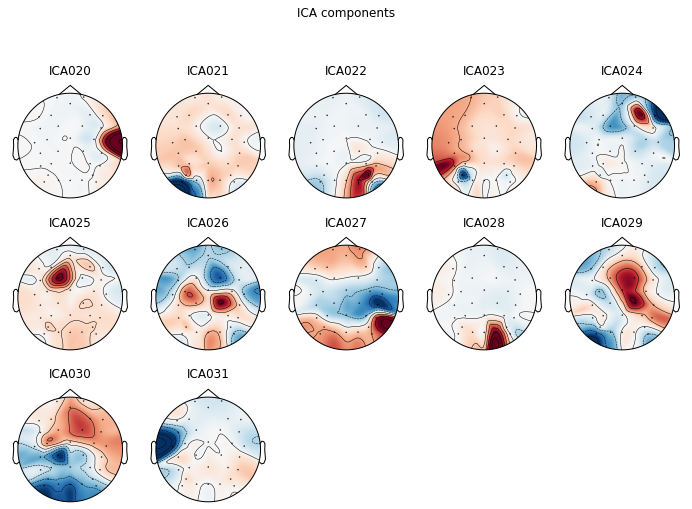

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x526.68 with 12 Axes>]

In [22]:
ica.plot_sources(filt_raw)
ica.plot_components(res = 64)

In [23]:
# ica.plot_properties(filt_raw, picks = [0,1])

In [24]:
# ica.plot_overlay(filt_raw, exclude=[4,5], picks='eeg')

## 4. Epoching

In [25]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [26]:
# ### https://www.sciencedirect.com/science/article/pii/S1746809410000558
event_id = {'Non-Target' : 1, "Target" : 2}
tmin = -0.1
tmax = 0.7
picks = eeg_channels
epochs = getEpochs(raw_s1, event_id, tmin, tmax, picks)

636 events found
Event IDs: [1 2]
sample drop %:  0.0


In [27]:
X = epochs.get_data()
y = epochs.events[:, 1]

print(X.shape)
print(y.shape)

(636, 32, 410)
(636,)


#### Plotting ERP of targets vs. non-targets

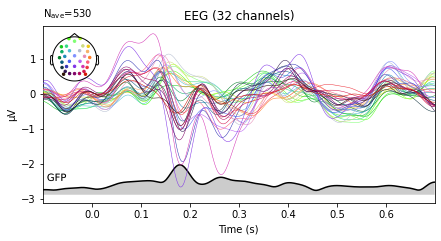

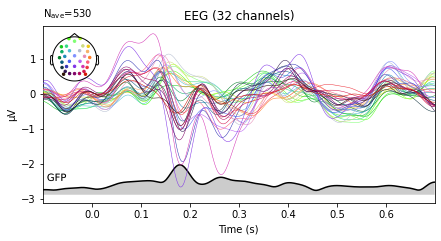

In [28]:
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')

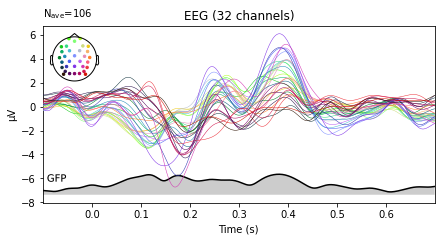

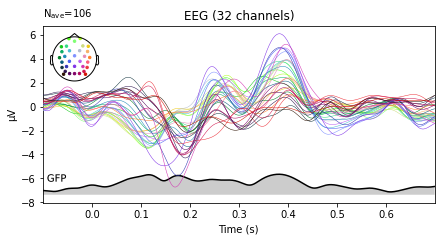

In [29]:
# evoked_non = epochs['Non-Target'].average()
# evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

#### Plotting scalp topographies

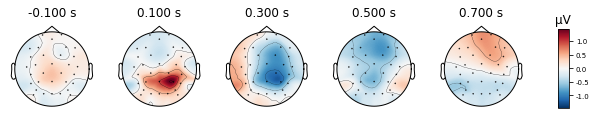

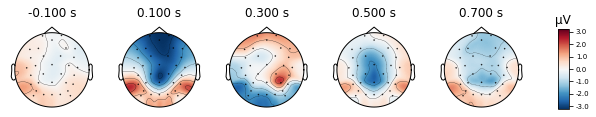

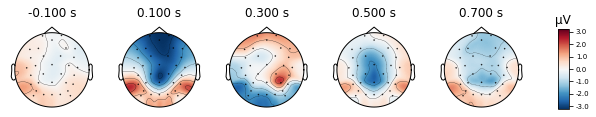

In [30]:
times = np.linspace(-0.1, 0.7, 5)
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times = times, colorbar= True)

#### Plotting ERP together with topographies

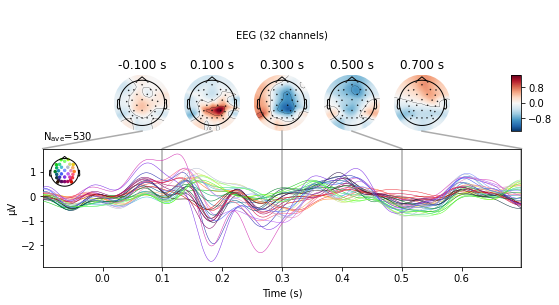

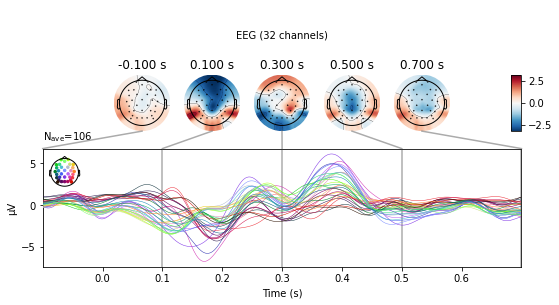

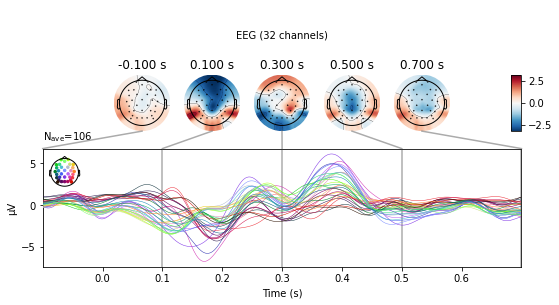

In [31]:
evoked_non.plot_joint(times=times)
evoked_target.plot_joint(times=times)

#### Image Plots

Not setting metadata
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


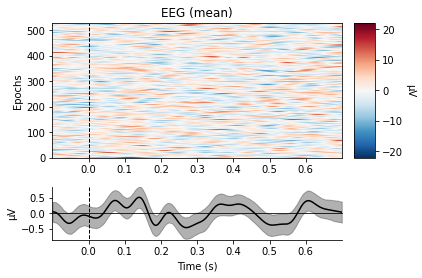

Not setting metadata
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


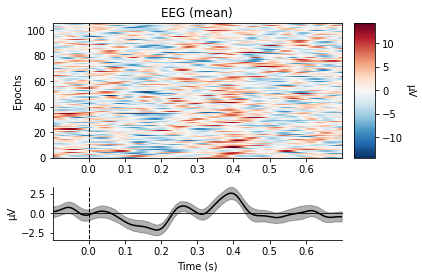

[<Figure size 432x288 with 3 Axes>]

In [32]:
epochs['Non-Target'].plot_image(picks='eeg', combine='mean')
epochs['Target'].plot_image(picks='eeg', combine='mean')

##### Comparing Evoked objects

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


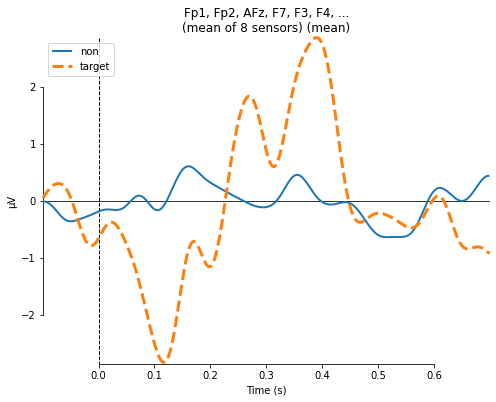

More than 6 channels, truncating title ...
combining channels using "median"
combining channels using "median"


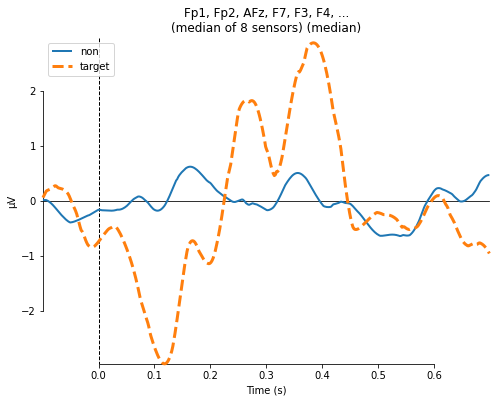

combining channels using "gfp"
combining channels using "gfp"


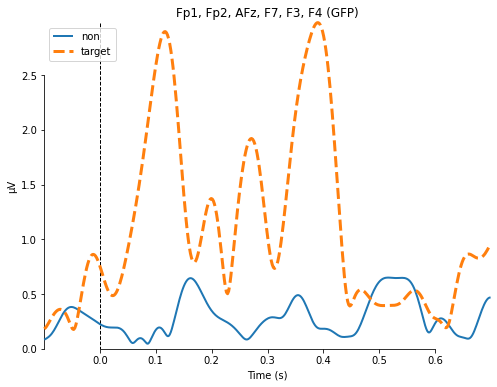

More than 6 channels, truncating title ...
combining channels using "<function custom_func at 0x000001B32B13D310>"
combining channels using "<function custom_func at 0x000001B32B13D310>"


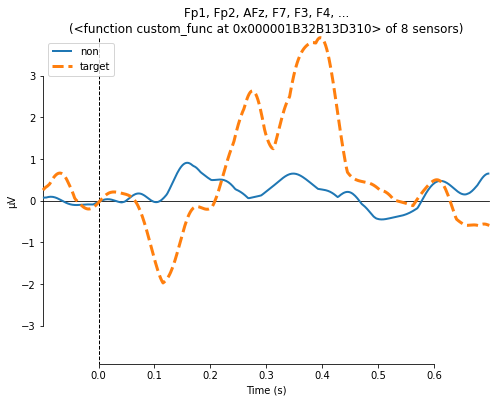

In [33]:
def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}
for combine in ('mean', 'median', 'gfp', custom_func):
    mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine=combine,
                                colors=dict(non=0, target=1),
                                linestyles=dict(non='solid', target='dashed'),
                                 styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

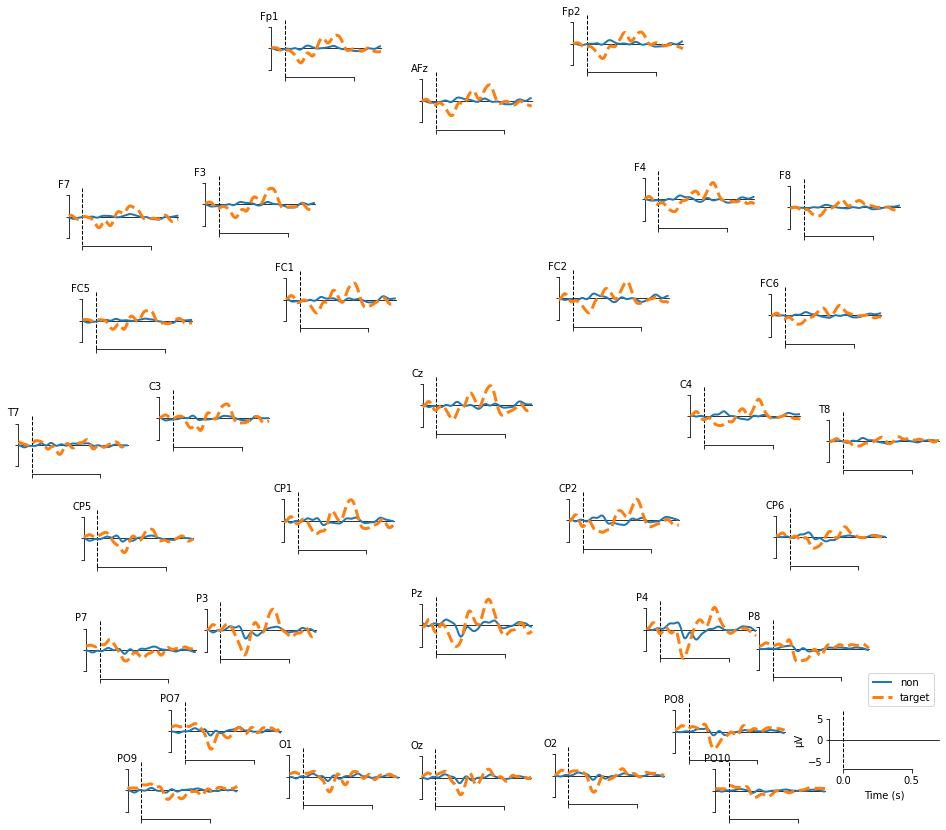

[<Figure size 1296x1008 with 33 Axes>]

In [34]:
mne.viz.plot_compare_evokeds(total_evoked, picks='eeg',
                                colors=dict(non=0, target=1), axes='topo',
                                linestyles=dict(non='solid', target='dashed'),
                            styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

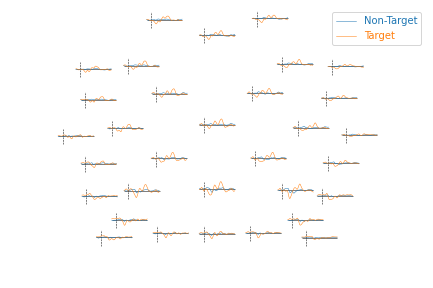

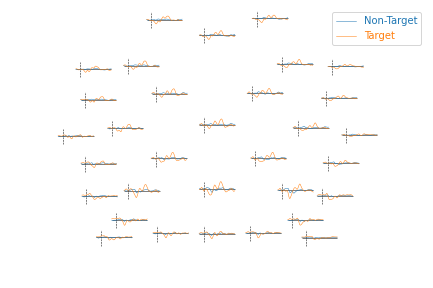

In [35]:
evokeds = [epochs[name].average() for name in ('Non-Target', 'Target')]
mne.viz.plot_evoked_topo(evokeds, layout_scale=1)